In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pinns import *

In [3]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

## Brusselator PDEs

> The Brusselator PDEs for two species are
<h3><center>$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + A - (B+1)u + u^2v$</center></h3>

<h3><center>$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v + Bu - u^2 v$</center></h3>

for diffusion constants $D_u$, $D_v$, and model parameters $A, B > 0$.
Therefore, the kinetic terms are

<h3><center>$f(u,v) = A - (B+1)u + u^2v$</center></h3>
<h3><center>$g(u,v) = Bu - u^2 v$</center></h3>

<h3><center>$u^* = A$</center></h3>
<h3><center>$v^* = \frac{B}{A}$</center></h3>



In [5]:
with open('./turing_Brusselator.npy', 'rb') as f:
    sol = np.load(f)

In [45]:
torch.manual_seed(42)
np.random.seed(42)

D_U = 0.0016
D_V = 0.0135

x = torch.linspace(0, 0.5, 32, device=dev_str)
y = torch.linspace(0, 0.5, 32, device=dev_str)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T
# To turn the tensor to a leaf node, we detach and clone it here
data_X = data_X.detach().clone()
data_X.requires_grad = True


data_x = torch.linspace(0, 0.5, 128).to(device)
data_y = torch.linspace(0, 0.5, 128).to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
physics_X = torch.vstack([X.flatten(), Y.flatten()]).T
# To turn the tensor to a leaf node, we detach and clone it here
physics_X = physics_X.detach().clone()
physics_X.requires_grad = True

data_U = torch.from_numpy(sol[0, :, :].flatten())
data_V = torch.from_numpy(sol[1, :, :].flatten())
data_f = torch.vstack([data_U, data_V]).T.to(device)



A = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=f"{device.type}:{device.index}"))
#A, B = 4.5, 13.29
sampled_As = []
B = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=f"{device.type}:{device.index}"))
sampled_Bs = []




lb = torch.tensor([0., 0.]).to(device)
ub = torch.tensor([0.5, 0.5]).to(device)
model = Net_dense_normalised([2, 512, 512, 512, 2], lb, ub).to(device)

optimizer = torch.optim.Adam([
                {'params': model.parameters()},
                {'params': [A, B], 'lr': 0.1}
            ], lr=1e-4, weight_decay=0.0001)
epochs = 1000000
loss_data = 0.0
lambda_data = torch.nn.Parameter(torch.ones(1, device=f"{device.type}:{device.index}"))*0.5#1.0
loss_physics = 0.0
lambda_physics = torch.nn.Parameter(torch.ones(1, device=f"{device.type}:{device.index}"))*0.5#5e-3

losses = np.zeros((2, epochs))

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # data loss
    data_f_hat = model(data_X).squeeze()
    loss_data = torch.mean((data_f - data_f_hat)**2)

    #################################
    # boundary loss
    # boundary_f_hat = model(boundary_X).squeeze()
    # loss_boundary = torch.mean((boundary_f - boundary_f_hat)**2)

    #################################
    # physics derivatives
    physics_f = model(physics_X).squeeze()
    U = physics_f[:,0]
    V = physics_f[:,1]
    dxy  = torch.autograd.grad(physics_f, physics_X, torch.ones_like(physics_f), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx),  create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy),  create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacian = dx2 + dy2
        
    FU = torch.exp(A) - (torch.exp(B) + 1) * U + U*U*V
    FV = torch.exp(B) * U - U*U*V
    
    dudt = D_U * laplacian + FU
    dvdt = D_V * laplacian + FV
    ################################
    # physics loss
    # Construct the physics loss here
    loss_physics = torch.mean(dudt**2 + dvdt**2)    
    
    total_loss = (
        +lambda_data*loss_data
        +lambda_physics*loss_physics        
                    )
    
    
    total_loss.backward(retain_graph=True)
    
    optimizer.step()
    
    losses[:,i] = (loss_data.item(), loss_physics.item())
    sampled_As.append(A.item())
    sampled_Bs.append(B.item())
    
#     a, b = torch.sum(data_X.grad**2).item(), torch.sum(physics_X.grad**2).item()
#     a2,b2 = max(a,1e-4), max(b,1e-4)
#     lambda_physics = a2/(a2+b2)
#     lambda_data = 1.0 - lambda_physics
    grad_data, grad_phy = torch.sum(data_X.grad**2).item(), torch.sum(physics_X.grad**2).item()
    loss_data, loss_phy = losses[0,i], losses[1,i]
    w1 = loss_data**2/np.sqrt(grad_data)
    w2 = loss_phy**2/np.sqrt(grad_phy)
    lambda_physics = w2/(w1+w2)
    lambda_data = 1.0 - lambda_physics
  
        
    
    if i%20000 == 0:
        print(f"Epoch: {i}")
        print(f"loss data: {losses[0,i]:.6f}, loss physics: {losses[1,i]:.6f}")
        print(f"A: {np.exp(sampled_As[-1]):.4f}, B: {np.exp(sampled_Bs)[-1]:.4f}")
        print(f"grad_data: {a:.6f}, grad_physics: {b:.6f}")        
        print(f"lambda_data: {lambda_data:.6f}, lambda_physics: {lambda_physics:.6f}")
    
    


Epoch: 0
loss data: 21.942837, loss physics: 9.634960
A: 2.4596, B: 2.4596
grad_data: 544251.000000, grad_physics: 68952.882812
lambda_data: 0.944571, lambda_physics: 0.055429
Epoch: 20000
loss data: 8.897208, loss physics: 3.544166
A: 0.3347, B: 6.0818
grad_data: 544251.000000, grad_physics: 68952.882812
lambda_data: 0.695429, lambda_physics: 0.304571
Epoch: 40000
loss data: 8.520902, loss physics: 3.836043
A: 0.1161, B: 6.1387
grad_data: 544251.000000, grad_physics: 68952.882812
lambda_data: 0.708253, lambda_physics: 0.291747
Epoch: 60000
loss data: 6.183705, loss physics: 2.336198
A: 3.7111, B: 12.0209
grad_data: 544251.000000, grad_physics: 68952.882812
lambda_data: 0.800599, lambda_physics: 0.199401
Epoch: 80000
loss data: 5.978138, loss physics: 2.405463
A: 3.5675, B: 11.8063
grad_data: 544251.000000, grad_physics: 68952.882812
lambda_data: 0.791579, lambda_physics: 0.208421
Epoch: 100000
loss data: 6.466941, loss physics: 2.286620
A: 3.0412, B: 9.4311
grad_data: 544251.000000, g

Epoch: 920000
loss data: 0.852701, loss physics: 2.317556
A: 5.6603, B: 7.6260
grad_data: 544251.000000, grad_physics: 68952.882812
lambda_data: 0.279644, lambda_physics: 0.720356
Epoch: 940000
loss data: 0.486626, loss physics: 0.318368
A: 7.9037, B: 8.9885
grad_data: 544251.000000, grad_physics: 68952.882812
lambda_data: 0.869808, lambda_physics: 0.130192
Epoch: 960000
loss data: 0.323690, loss physics: 0.229267
A: 9.1486, B: 9.9348
grad_data: 544251.000000, grad_physics: 68952.882812
lambda_data: 0.850069, lambda_physics: 0.149931
Epoch: 980000
loss data: 0.276626, loss physics: 0.197755
A: 11.5718, B: 11.4084
grad_data: 544251.000000, grad_physics: 68952.882812
lambda_data: 0.847262, lambda_physics: 0.152738


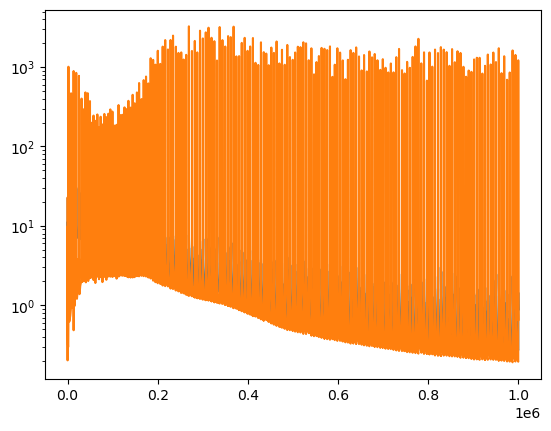

11.616870344797935 11.416816983576119 986870


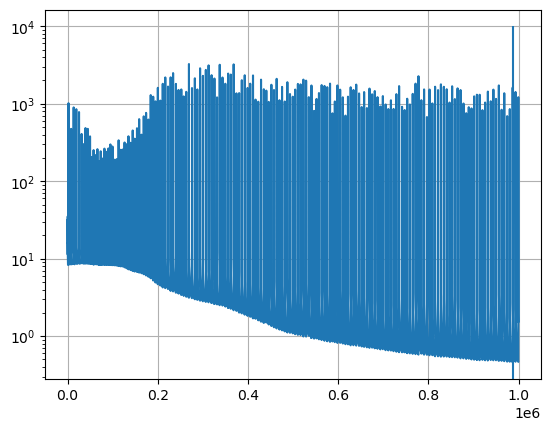

In [46]:

plt.plot(losses[0,:])
plt.plot(losses[1,:])
plt.yscale('log'); plt.show()
plt.plot(np.sum(losses, axis=0))

index = np.argmin(np.sum(losses, axis=0)[20:])
print(np.exp(sampled_As[index]), np.exp(sampled_Bs[index]), index)
plt.yscale('log'); plt.vlines(index, 0, 10000);plt.grid();

plt.show()


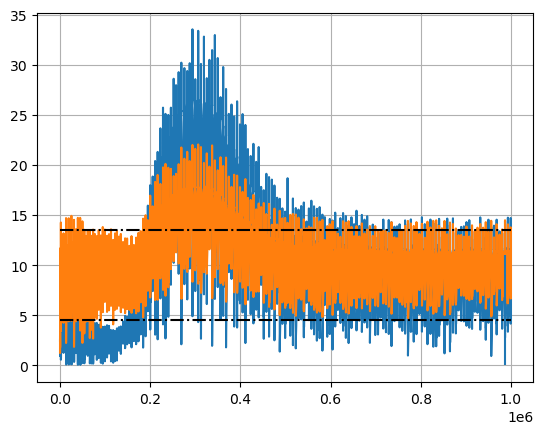

11.616870344797935 11.416816983576119 986870
5.3090908183140995 7.118691784523239


In [47]:
plt.plot(np.exp(sampled_As))
plt.plot(np.exp(sampled_Bs))
plt.hlines(4.5, 0,epochs, linestyles='-.', color='black')
plt.hlines(13.5, 0,epochs, linestyles='-.', color='black')
plt.vlines(index, 0, 11);plt.grid()
plt.show()
index = np.argmin(np.sum(losses, axis=0)[20:])
print(np.exp(sampled_As[index]), np.exp(sampled_Bs[index]), index)
print(np.exp(sampled_As[-1]), np.exp(sampled_Bs[-1]))

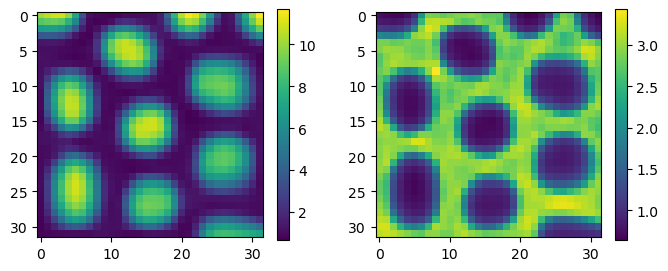

In [48]:
solution = model(data_X).cpu().detach()
U_hat = solution[:, 0].reshape((32, 32))
V_hat = solution[:, 1].reshape((32, 32))
index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(U_hat)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(V_hat)
plt.colorbar(shrink=.75)
plt.show()